## Data Cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!rm -r sample_data

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', 150)

!pip install --quiet autokeras
import autokeras as ak

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PFA/final_data.csv')
df = df.drop(['Unnamed: 0','len_caption','len_bio','nb_emoji','hashtags','clean_captions','dates','post_ids'],axis=1)
df = df.drop_duplicates(subset='username', keep='first')
new_column_names = {
    'post_captions': 'captions',
}

columns_order = ['username','bio','posts_count','followers_count','followees_count','post_captions','O', 'C', 'E', 'A','N','avg_len_caption','nb_hashtags',
       'nb_mentions', 'duration', 'frequency', 'avg_emojis',
       'hashtags_unique']
df = df[columns_order]
df = df.rename(columns=new_column_names)

num_cols = ['posts_count','followers_count','followees_count','avg_len_caption','nb_hashtags','nb_mentions','duration','frequency','avg_emojis']
mean_values = df[num_cols].mean(axis=0)
std_values = df[num_cols].std(axis=0)
mean_df = pd.DataFrame(mean_values, columns=['Mean'])
std_df = pd.DataFrame(std_values, columns=['Standard Deviation'])
pd.concat([mean_df, std_df], axis=1).T

,posts_count,followers_count,followees_count,avg_len_caption,nb_hashtags,nb_mentions,duration,frequency,avg_emojis
Mean,1132.948864,5.416222e+06,1271.628788,266.775577,273.638258,0.414773,800.691288,9.098853,1.910339
Standard Deviation,1579.897259,3.198482e+07,1296.381033,295.765561,463.213755,1.656546,842.021698,11.697160,3.027327


In [ ]:
df[num_cols] = df[num_cols].apply(lambda x: (x - x.mean()) / x.std())
df = df.drop(['captions','bio','username','hashtags_unique'],axis=1)
df

,posts_count,followers_count,followees_count,O,C,E,A,N,avg_len_caption,nb_hashtags,nb_mentions,duration,frequency,avg_emojis
0,-0.516457,-0.165813,-0.580561,0,1,0,1,1,0.229927,-0.521656,-0.250384,-0.583941,-0.513702,0.188173
1,1.367210,-0.155331,-0.409315,0,0,0,1,1,0.555788,-0.575627,-0.250384,-0.644510,-0.557302,-0.130639
2,-0.160738,-0.148096,-0.234213,0,1,0,1,0,-0.331875,-0.232373,-0.250384,-0.625508,-0.543624,-0.247429
3,-0.403791,-0.168119,-0.321378,0,1,1,0,0,-0.391816,-0.489274,0.353282,-0.580378,-0.511137,-0.469173
4,-0.682923,-0.161234,-0.754893,1,0,0,1,0,-0.486214,0.862154,-0.250384,-0.338104,-0.336736,-0.205862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,-0.637351,-0.084985,-0.589818,0,1,0,0,1,-0.666867,-0.396444,-0.250384,2.113139,1.700405,-0.456591
531,-0.541775,-0.168356,0.018028,0,1,1,1,1,0.497301,-0.551880,-0.250384,-0.917662,-0.753931,0.138624
532,-0.538610,-0.139750,-0.513452,0,1,1,0,1,-0.494904,0.158376,-0.250384,-0.428363,-0.401709,-0.455960
533,-0.386702,-0.169036,-0.892198,0,1,0,1,1,0.671493,-0.523815,-0.250384,-0.842842,-0.700072,-0.082693


$$$$

$$$$

### Prepare Data

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df,test_size=0.2, random_state=42)

x_train = np.array(df_train[num_cols])
y_train = [np.array(df_train[trait]) for trait in ['O', 'C', 'E', 'A','N']]

x_valid = np.array(df_valid[num_cols])
y_valid = [np.array(df_valid[trait]) for trait in ['O', 'C', 'E', 'A','N']]

x_train.shape,x_valid.shape

((422, 9), (106, 9))

In [ ]:
# x_test = np.array(df_test[num_cols])
# y_test =  [np.array(df_test[trait]) for trait in ['O', 'C', 'E', 'A','N']]
# x_test.shape

(53, 9)

$$$$

## Train Model

In [ ]:
clf = ak.AutoModel(
    inputs=ak.Input(),
    outputs=[ak.ClassificationHead(
            loss="binary_crossentropy",
            metrics=["accuracy"],
            name=trait
             )
    for trait in ['O', 'C', 'E', 'A','N']],
    overwrite=True,
    max_trials=100,
    objective='val_loss'
)

In [ ]:
clf.fit(x_train, y_train, validation_data=(x_valid, y_valid),epochs=200)

In [ ]:
best_model = clf.export_model()
best_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_to_float32           │ (None, 9)              │              0 │ input_layer[0][0]      │
│ (CastToFloat32)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            320 │ cast_to_float32[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32)             │            128 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32)             │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          1,056 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32)             │            128 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             33 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             33 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             33 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             33 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │             33 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ O (Activation)            │ (None, 1)              │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ C (Activation)            │ (None, 1)              │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ E (Activation)            │ (None, 1)              │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ A (Activation)            │ (None, 1)              │              0 │ dense_5[0][0]          │
├──────────────────────

 Total params: 1,797 (7.02 KB)

 Trainable params: 1,669 (6.52 KB)

 Non-trainable params: 128 (512.00 B)

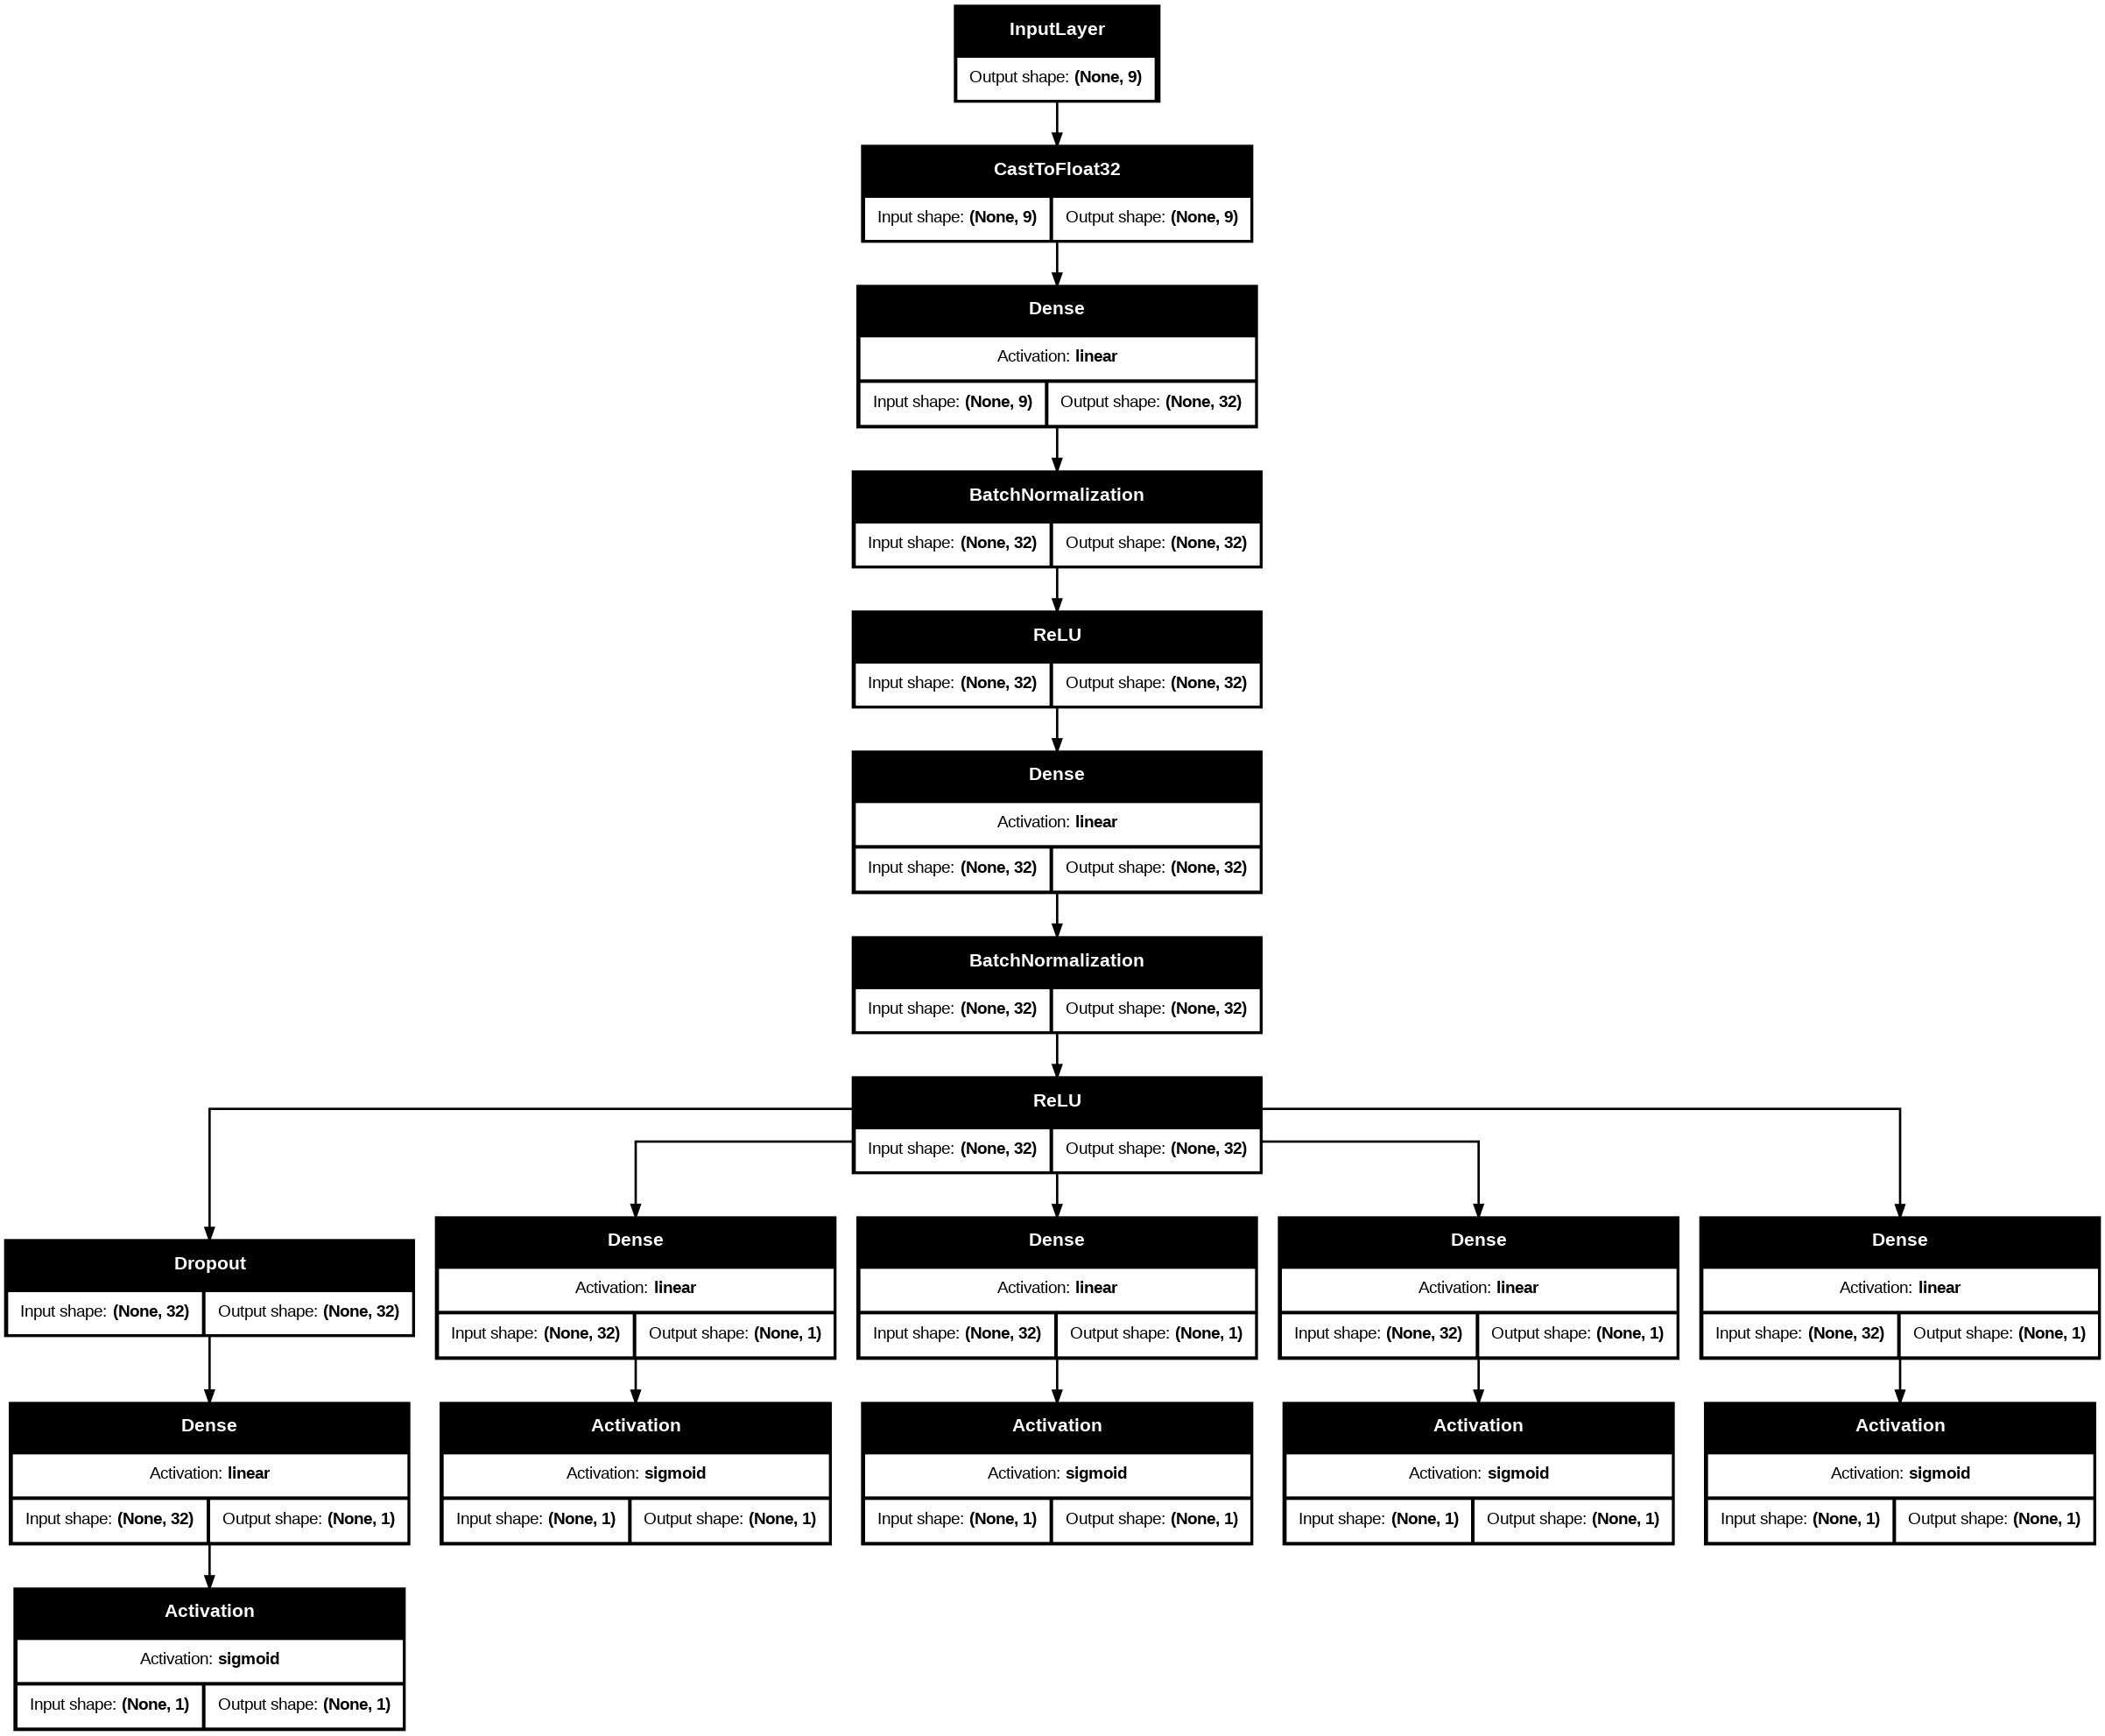

In [ ]:
import keras
keras.utils.plot_model(best_model,show_shapes=True,show_layer_activations=True,dpi=96)

In [ ]:
best_hyperparameters = clf.tuner.get_best_hyperparameters()[0]
best_hyperparameters.values

{'general_block_1/dense_block_1/use_batchnorm': True,
 'general_block_1/dense_block_1/num_layers': 2,
 'general_block_1/dense_block_1/units_0': 32,
 'general_block_1/dense_block_1/dropout': 0.0,
 'general_block_1/dense_block_1/units_1': 32,
 'O/dropout': 0,
 'C/dropout': 0.5,
 'E/dropout': 0,
 'A/dropout': 0,
 'N/dropout': 0,
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'general_block_1/dense_block_1/units_2': 16}

In [ ]:
best_model.evaluate(x_valid,y_valid)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - A_accuracy: 0.7506 - C_accuracy: 0.7226 - E_accuracy: 0.6556 - N_accuracy: 0.8221 - O_accuracy: 0.5918 - loss: 2.8370


[2.833644390106201,
 0.7358490824699402,
 0.7075471878051758,
 0.6415094137191772,
 0.8207547068595886,
 0.6226415038108826]

In [ ]:
preds = best_model(x_valid)
preds

**Best Thresholds**

In [ ]:
import tensorflow as tf

best_acc_trait = {}
for i,trait in tqdm(enumerate(['O', 'C', 'E', 'A','N']),total=5):
    best_acc = 0
    best_th = 0
    p = preds[i]
    gt = y_valid[i]
    for th in tqdm(np.arange(0.001,1,0.001)):
          m1 = tf.keras.metrics.BinaryAccuracy(threshold=th)
          m1.update_state(gt,p)
          if m1.result().numpy() > best_acc:
            best_acc = m1.result().numpy()
            best_th = th
    best_acc_trait[trait] = {'best_accuracy':best_acc,
                             'best_threshold':best_th
                             }
best_acc_trait

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

{'O': {'best_accuracy': 0.6981132, 'best_threshold': 0.645},
 'C': {'best_accuracy': 0.7358491, 'best_threshold': 0.531},
 'E': {'best_accuracy': 0.6792453, 'best_threshold': 0.643},
 'A': {'best_accuracy': 0.7830189, 'best_threshold': 0.558},
 'N': {'best_accuracy': 0.8207547, 'best_threshold': 0.364}}

In [ ]:
best_model.save("/content/drive/MyDrive/PFA/best_model_num.keras")

$$$$

$$$$

## Real Data

In [ ]:
!pip install --quiet autokeras
!pip install --quiet apify_client
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 150)
import autokeras as ak
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import re
plt.style.use('ggplot')

In [ ]:
best_thresholds = {
 'O': 0.645,
 'C': 0.531,
 'E': 0.643,
 'A': 0.558,
 'N': 0.364}

mean_std_data = {
    '': ['Mean', 'Standard Deviation'],
    'postsCount': [1132.948864, 1579.897259],
    'followersCount': [5.416222e+06, 3.198482e+07],
    'followsCount': [1271.628788, 1296.381033],
    'avg_len_caption': [266.775577, 295.765561],
    'nb_hashtags': [273.638258, 463.213755],
    'nb_mentions': [0.414773, 1.656546],
    'duration': [800.691288, 842.021698],
    'frequency': [9.098853, 11.697160],
    'avg_emojis': [1.910339, 3.027327]
}
mean_std_df = pd.DataFrame(mean_std_data).set_index('')
model = keras.models.load_model('/content/drive/MyDrive/PFA/best_model_num.keras')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_to_float32           │ (None, 9)              │              0 │ input_layer[0][0]      │
│ (CastToFloat32)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            320 │ cast_to_float32[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32)             │            128 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32)             │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          1,056 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32)             │            128 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             33 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             33 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             33 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             33 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │             33 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ O (Activation)            │ (None, 1)              │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ C (Activation)            │ (None, 1)              │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ E (Activation)            │ (None, 1)              │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ A (Activation)            │ (None, 1)              │              0 │ dense_5[0][0]          │
├──────────────────────

 Total params: 5,137 (20.07 KB)

 Trainable params: 1,669 (6.52 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 3,340 (13.05 KB)

**Scrap Data**

In [ ]:
def count_emojis(text):
    emoji_pattern = r'(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])'
    emojis = re.findall(emoji_pattern, text)
    return len(emojis)
mean_std_df

,postsCount,followersCount,followsCount,avg_len_caption,nb_hashtags,nb_mentions,duration,frequency,avg_emojis
,,,,,,,,,
Mean,1132.948864,5416222.0,1271.628788,266.775577,273.638258,0.414773,800.691288,9.098853,1.910339
Standard Deviation,1579.897259,31984820.0,1296.381033,295.765561,463.213755,1.656546,842.021698,11.697160,3.027327


In [ ]:
from apify_client import ApifyClient

user = "cristiano" # @param ["cristiano","jlo","katyperry"] {allow-input: true}
user = [user]

APIToken = "apify_api_ybO1RDN4QILAesZaJE6XzdRRBbrtCt2GXpoB" # @param {type:"string"}
apify_client = ApifyClient(APIToken)

actor_collection_client = apify_client.actors()
actor_collection_client.list().items

post_actor = ""
profile_actor = ""
for actor in actor_collection_client.list().items:
  if actor['title'] == 'Instagram Post Scraper':
    post_actor = actor['id']
  if actor['title'] == 'Instagram Profile Scraper':
    profile_actor = actor['id']

user = ['cristiano']
print(post_actor)
print(profile_actor)

nH2AHrwxeTRJoN5hX
dSCLg0C3YEZ83HzYX


In [ ]:
run_input = {
    "username": user,
    "resultsLimit": 100,
}

run = apify_client.actor(post_actor).call(run_input=run_input)
desired_order = ['inputUrl', 'caption', 'timestamp']
post_data = []
for item in apify_client.dataset(run["defaultDatasetId"]).iterate_items():
    data = {}
    for k in desired_order:
      try:
        data[k] = item[k]
      except Exception as e:
        pass
    post_data.append(data)
post_data = pd.DataFrame(post_data)
post_data

CPU times: user 1.05 s, sys: 133 ms, total: 1.19 s
Wall time: 2min 50s


,inputUrl,caption,timestamp
0,https://www.instagram.com/cristiano,This is @alnassr! Let’s go to Jeddah! 💪,2024-05-27T20:56:12.000Z
1,https://www.instagram.com/cristiano,Introducing my newest NFT collection which launches today on #Binance.\n\nForever Worldwide: The Road to Saudi Arabia celebrates my football journ...,2024-05-29T08:00:45.000Z
2,https://www.instagram.com/cristiano,"Proud to make history as the first top scorer in 4 countries 🏴󠁧󠁢󠁥󠁮󠁧󠁿 🇪🇸 🇮🇹 🇸🇦 A huge thank you to all the clubs, teammates and staff who helped me...",2024-05-28T09:27:29.000Z
3,https://www.instagram.com/cristiano,Cristiano Ronaldo receives the #RoshnSaudiLeague Top Scorer award! 🐐\n\nالتاريخي 🐐\n\nكريستيانو رونالدو يفوز بجائزة أفضل هداف عن موسم 2023-2024 ✨\...,2024-05-29T18:00:13.000Z
4,https://www.instagram.com/cristiano,"Play, learn, grow, repeat. 🔁 Thank you all for your support this season. We will come back even stronger!",2024-06-01T19:50:31.000Z
...,...,...,...
95,https://www.instagram.com/cristiano,Taking sports to a whole new dimension. Unparalleled vision and execution. Can’t stop being amazed. 💪🏼👊🏼🇸🇦,2023-12-23T22:42:30.000Z
96,https://www.instagram.com/cristiano,"Three more points! 🔝 Thankful to all my team mates who helped me reach my 1200th match. What a ride, but we’re not done yet! 🔥",2023-12-08T20:14:06.000Z
97,https://www.instagram.com/cristiano,Wining team 🤷🏽‍♂️😅💪🏽,2023-12-07T16:46:27.000Z
98,https://www.instagram.com/cristiano,"Funchal is the capital and tourist centre of Madeira. A vibrant city, full of tradition and history, that expands from the Atlantic shore to the g...",2023-12-06T18:41:23.000Z


In [ ]:
run_input = {"usernames": user }
run = apify_client.actor(profile_actor).call(run_input=run_input)
desired_order = ['inputUrl','fullName', 'followsCount','followersCount','postsCount']
profile_data = []
for item in apify_client.dataset(run["defaultDatasetId"]).iterate_items():
    data = {}
    for k in desired_order:
      try:
        data[k] = item[k]
      except Exception as e:
        pass
    # print(data)
    profile_data.append(data)
profile_data = pd.DataFrame(profile_data)
profile_data

,inputUrl,fullName,followsCount,followersCount,postsCount
0,https://www.instagram.com/cristiano,Cristiano Ronaldo,567,630735099,3687


In [ ]:
df = pd.merge(profile_data, post_data, on='inputUrl', how='outer')
df.drop(['inputUrl','fullName'],axis=1,inplace=True)
order = ['postsCount','followersCount','followsCount','caption','timestamp']
df = df[order]
df = df.groupby(['postsCount', 'followersCount','followsCount']).agg({
    'caption': list,
    'timestamp': list
}).reset_index()
df

,postsCount,followersCount,followsCount,caption,timestamp
0,3687,630735099,567,"[This is @alnassr! Let’s go to Jeddah! 💪, Introducing my newest NFT collection which launches today on #Binance.\n\nForever Worldwide: The Road to...","[2024-05-27T20:56:12.000Z, 2024-05-29T08:00:45.000Z, 2024-05-28T09:27:29.000Z, 2024-05-29T18:00:13.000Z, 2024-06-01T19:50:31.000Z, 2024-05-24T14:3..."


In [ ]:
df['dates'] = df['timestamp'].apply(lambda x: [pd.to_datetime(ts, errors='coerce') for ts in x])
df['len_caption'] = [[len(x) for x in c] for c in df['caption']]
df['avg_len_caption'] = df['len_caption'].apply(lambda x: np.average(x))
df['nb_hashtags'] = df['caption'].apply(lambda x: sum([caption.count('#') for caption in x]))
df['nb_mentions'] = df['caption'].apply(lambda x: sum([caption.count('@') for caption in x]))
df['duration'] = df['dates'].apply(lambda x: (x[0] - x[-1]).days)
df['frequency'] = df.apply(lambda row: row['duration'] / len(row['dates']), axis=1)
df['nb_emoji']= [[count_emojis(x) for x in c] for c in df['caption']]
df['avg_emojis'] = df['nb_emoji'].apply(lambda x: np.average(x) if len(x) > 0 else 0)
df = df.drop(['timestamp','len_caption','nb_emoji','dates','caption'],axis=1)
df = (df - mean_std_df.loc['Mean']) / mean_std_df.loc['Standard Deviation']
df

,postsCount,followersCount,followsCount,avg_len_caption,nb_hashtags,nb_mentions,duration,frequency,avg_emojis
0,3687,630735099,567,86.49,57,27,170,1.7,0.65


**Predictions**

In [ ]:
x = np.array(df)
predictions = model(x)
trait_keys = ['O', 'C', 'E', 'A', 'N']
binary_predictions = {}
prob_predictions = {}

for idx, trait in enumerate(trait_keys):
    threshold = best_thresholds[trait]
    prob_predictions[trait] = np.squeeze(predictions[idx]).item()
    binary_predictions[trait] = (np.squeeze(predictions[idx]) > threshold).astype(int)
binary_predictions,prob_predictions

({'O': 1, 'C': 0, 'E': 0, 'A': 1, 'N': 0},
 {'O': 0.9902955889701843,
  'C': 0.13001617789268494,
  'E': 0.0016110368305817246,
  'A': 0.6411078572273254,
  'N': 0.0041401563212275505})

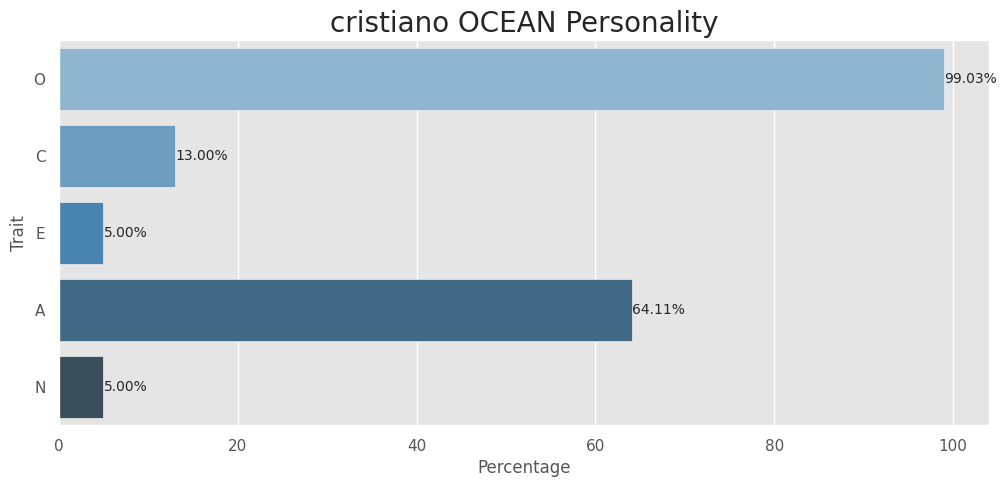

In [ ]:
plt.figure(figsize=(12, 5))
prob_predictions = {k:(v*100 if v >0.05 else 5) for k,v in prob_predictions.items()}
sns.barplot(x=list(prob_predictions.values()), y=list(prob_predictions.keys()), hue=list(prob_predictions.keys()), palette="Blues_d", dodge=False, legend=False)
for index, value in enumerate(prob_predictions.values()):
    plt.text(value, index, f'{value:.2f}%', va='center')

plt.xlabel('Percentage')
plt.ylabel("Trait")
plt.title(f"{user[0]} OCEAN Personality",fontsize=20)
plt.show()